# tools for pre-processing images

In [26]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
__author__ = 'Pascal Louis <plouis35@gmail.com>'
__version__ = '0.1 alpha'
__keywords__ = ['astronomy', 'astropy', 'astroalign', 'ccdproc', 'matplotlib']


## configure display

In [3]:
### allow full width of browser
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

### matplotlib settings
import matplotlib.pyplot as plt

%config InlineBackend.rc = {}
plt.style.use(['dark_background'])
plt.rcParams.update({'figure.max_open_warning': 0})      


## import libraries

In [22]:
import fnmatch, os
from astropy import units as u
from astropy.nddata import CCDData
from ccdproc import ImageFileCollection, cosmicray_median, cosmicray_lacosmic, gain_correct
from easycombiner import Images

### collect and sort (according to fit header 'date') file names using a wildcard filter
#def find_files(directory: str, files_filter: str, sort_key: str = 'date-obs'):
    #ic = ImageFileCollection(directory, glob_include=files_filter)
    #ic.sort([sort_key])
    #return (ic.files_filtered(include_path=True))

### simple image display
def show_image(img, title = 'no name') -> None:
    #img = lights_c[1]
    #p2, p98 = np.percentile(img, (2, 98))
    #l_rescale = sk.exposure.rescale_intensity(img, in_range=(p2, p98))
    #plt.imshow(l_rescale / np.max(l_rescale), cmap="gray")
    colormap = plt.cm.inferno
    cuts = (2, 98)
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    plt.tight_layout()
    im = ax.imshow(img, origin='lower', aspect='auto', cmap=colormap)
    cb = plt.colorbar(im)
    im.set_clim(np.percentile(img, cuts))
    ax.set_title(title)
    fig.canvas.header_visible = False
    plt.show()



## define targets

In [5]:
CAPTURE_DIR='../../../CAPTURES/2023_RENNES_L3_TP/'
#CAPTURE_DIR='../../../CAPTURES/2023_RENNES_L3_TP/images_spectro/images_tp_spectro/'
BIAS_FILES = "offset-*.fit"
DARK_FILES = "noir-600-*.fit"
FLAT_FILES = "flat-*.fit"
CALIB_FILES = "neon-*.fit"
SCIENCE_FILES = "agdra-*.fit"
TRIM_REGION = '600, 600, 2700, 1400'              # x1, y1, x2, y2 
#TRIM_REGION = None
EXPOSURE_KEY = 'EXPTIME'
camera_electronic_gain = 0.27 * u.electron/u.adu   # atik 460ex
camera_readout_noise = 5.0 * u.electron     # atik 460ex


## define logger

In [6]:
### logger prints after every notebook cell
import sys
import logging

logging.basicConfig(
    format='%(asctime)s [%(levelname)s] - %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    stream=sys.stdout,
)
logger = logging.getLogger('notebook')


## create masterbias

In [11]:
### create master bias
if (BIAS_FILES is not None): # and not (os.path.exists(CAPTURE_DIR + 'masterbias.fit')):
    master_bias = Images.from_fit(dir = CAPTURE_DIR, filter = BIAS_FILES, 
                                  camera_electronic_gain = camera_electronic_gain, camera_readout_noise = camera_readout_noise) \
                        .trim(TRIM_REGION) \
                        .sigmaclip() 
                        #.median() 
                        #.offset(1500 * u.adu) \
    master_bias.write(CAPTURE_DIR + 'masterbias.fit', overwrite=True) 
    logger.info(f'min={master_bias.min()}, max={master_bias.max()}, avg={master_bias.mean()}')


2024-05-15 15:37:17 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/offset-1.fit loaded
2024-05-15 15:37:17 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/offset-2.fit loaded
2024-05-15 15:37:18 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/offset-3.fit loaded
2024-05-15 15:37:18 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/offset-4.fit loaded
2024-05-15 15:37:18 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/offset-5.fit loaded
2024-05-15 15:37:18 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/offset-6.fit loaded
2024-05-15 15:37:18 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/offset-7.fit loaded
2024-05-15 15:37:18 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/offset-8.fit loaded
2024-05-15 15:37:18 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/offset-9.fit loaded
2024-05-15 15:37:19 [INFO] - 9 images trimmed to (600, 600, 2700, 1400)
2024-05-15 15:37:19 [INFO] - sigmaclip combine on 9 images ...
2024-05-15 15:37:20 [INFO] -

## create masterdark

In [12]:
### create master dark
if (DARK_FILES is not None): # and not (os.path.exists(CAPTURE_DIR + 'masterdark.fit')):
    master_dark = Images.from_fit(dir = CAPTURE_DIR, filter = DARK_FILES, 
                                  camera_electronic_gain = camera_electronic_gain, camera_readout_noise = camera_readout_noise) \
                        .trim(TRIM_REGION) \
                        .bias_substract(master_bias) \
                        .sigmaclip() 
                        #.median() 
                        #.offset(1500 * u.adu) \
    master_dark.write(CAPTURE_DIR + 'masterdark.fit', overwrite=True) 
    logger.info(f'min={master_dark.min()}, max={master_dark.max()}, avg={master_dark.mean()}')


2024-05-15 15:37:31 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/noir-600-1.fit loaded
2024-05-15 15:37:31 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/noir-600-2.fit loaded
2024-05-15 15:37:32 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/noir-600-3.fit loaded
2024-05-15 15:37:32 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/noir-600-4.fit loaded
2024-05-15 15:37:32 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/noir-600-5.fit loaded
2024-05-15 15:37:32 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/noir-600-6.fit loaded
2024-05-15 15:37:32 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/noir-600-7.fit loaded
2024-05-15 15:37:32 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/noir-600-8.fit loaded
2024-05-15 15:37:33 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/noir-600-9.fit loaded
2024-05-15 15:37:33 [INFO] - 9 images trimmed to (600, 600, 2700, 1400)
2024-05-15 15:37:33 [INFO] - float32 bias substracted to 9 images
2024-05

## create masterflat

In [13]:
### create master flat
if (FLAT_FILES is not None): # and not (os.path.exists(CAPTURE_DIR + 'masterflat.fit')):
    master_flat = Images.from_fit(dir = CAPTURE_DIR, filter = FLAT_FILES, 
                                  camera_electronic_gain = camera_electronic_gain, camera_readout_noise = camera_readout_noise) \
                        .trim(TRIM_REGION) \
                        .bias_substract(master_bias) \
                        .sum()
#                        .median()
#                        .offset(1500 * u.adu) \
    master_flat.write(CAPTURE_DIR + 'masterflat.fit', overwrite=True) 
    logger.info(f'min={master_flat.min()}, max={master_flat.max()}, avg={master_flat.mean()}')


2024-05-15 15:38:02 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/flat-1.fit loaded
2024-05-15 15:38:02 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/flat-2.fit loaded
2024-05-15 15:38:02 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/flat-3.fit loaded
2024-05-15 15:38:02 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/flat-4.fit loaded
2024-05-15 15:38:03 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/flat-5.fit loaded
2024-05-15 15:38:03 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/flat-6.fit loaded
2024-05-15 15:38:03 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/flat-7.fit loaded
2024-05-15 15:38:03 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/flat-8.fit loaded
2024-05-15 15:38:03 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/flat-9.fit loaded
2024-05-15 15:38:03 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/flat-10.fit loaded
2024-05-15 15:38:04 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/flat-11.fit load

## create mastercalib

In [14]:
### create master calib
if (CALIB_FILES is not None): # and not (os.path.exists(CAPTURE_DIR + 'mastercalib.fit')):
    master_calib = Images.from_fit(dir = CAPTURE_DIR, filter = CALIB_FILES,
                                   camera_electronic_gain = camera_electronic_gain, camera_readout_noise = camera_readout_noise) \
                         .trim(TRIM_REGION) \
                         .bias_substract(master_bias) \
                         .sigmaclip()
#                         .median()
#                         .offset(1500 * u.adu) \
    master_calib.write(CAPTURE_DIR + 'mastercalib.fit', overwrite=True) 
    logger.info(f'min={master_calib.min()}, max={master_calib.max()}, avg={master_calib.mean()}')


2024-05-15 15:39:34 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/neon-4.fit loaded
2024-05-15 15:39:35 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/neon-3.fit loaded
2024-05-15 15:39:35 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/neon-1.fit loaded
2024-05-15 15:39:35 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/neon-2.fit loaded
2024-05-15 15:39:35 [INFO] - 4 images trimmed to (600, 600, 2700, 1400)
2024-05-15 15:39:35 [INFO] - float32 bias substracted to 4 images
2024-05-15 15:39:35 [INFO] - sigmaclip combine on 4 images ...
2024-05-15 15:39:36 [INFO] - min=17.194458 adu, max=64927.64 adu, avg=1940.6982 adu


## reduce science frames

In [27]:
### reduce science frames
master_sciences = Images.from_fit(dir = CAPTURE_DIR, filter = SCIENCE_FILES, 
                                  camera_electronic_gain = camera_electronic_gain, camera_readout_noise = camera_readout_noise) \
                        .trim(TRIM_REGION) \
                        .process_ccd(master_bias = master_bias, master_dark = master_dark, master_flat = master_flat, exposure_key = EXPOSURE_KEY) \
                        .spec_align(ref_image_index = 0)                        # fft based - best for spectra fields

#                        .star_align(ref_image_index = 0)                        # astro_align (triangles) based - best for stars fields
#                        .bias_substract(master_bias) \
#                        .dark_substract(master_dark, scale_exposure = True, exposure = EXPOSURE_KEY) \
#                        .flat_divide(master_flat) \
#                        .offset(1500 * u.adu) \

### optional: save individual frames
for i, frame in zip(range(0, len(master_sciences)), master_sciences):
    frame.write(f'{CAPTURE_DIR}science_reduced_{i}.fit', overwrite=True)
    logger.info(f'frame {i}: min={frame.min()}, max={frame.max()}, avg={frame.mean()}')

### combine science frames
master_science = master_sciences.sum() 
#master_science = master_sciences.median()
master_science.write(CAPTURE_DIR + 'masterscience.fit', overwrite=True) 
logger.info(f'master_science: min={master_science.min()}, max={master_science.max()}, avg={master_science.mean()}')


2024-05-15 15:56:32 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/agdra-1.fit loaded
2024-05-15 15:56:32 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/agdra-2.fit loaded
2024-05-15 15:56:32 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/agdra-3.fit loaded
2024-05-15 15:56:32 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/agdra-4.fit loaded
2024-05-15 15:56:32 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/agdra-5.fit loaded
2024-05-15 15:56:33 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/agdra-6.fit loaded
2024-05-15 15:56:33 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/agdra-7.fit loaded
2024-05-15 15:56:33 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/agdra-8.fit loaded
2024-05-15 15:56:33 [INFO] - image : ../../../CAPTURES/2023_RENNES_L3_TP/agdra-9.fit loaded
2024-05-15 15:56:33 [INFO] - 9 images trimmed to (600, 600, 2700, 1400)
2024-05-15 15:56:37 [INFO] - 9 images reduced
2024-05-15 15:56:37 [INFO] - align: fftconvolve runnin

## remove cosmics

In [35]:
from astropy.convolution import convolve, Gaussian2DKernel, Tophat2DKernel
from astropy.modeling.models import Gaussian2D
from astropy.convolution import Box2DKernel

### reduce and align science frames
logger.info(f'master_science: min={master_science.min()}, max={master_science.max()}, avg={master_science.mean()}')

gain_corrected = gain_correct(master_science, camera_electronic_gain)
logger.info(f'gain_corrected: min={gain_corrected.min()}, max={gain_corrected.max()}, avg={gain_corrected.mean()}')

"""
master_science_clean = cosmicray_lacosmic(gain_corrected,
                                          #satlevel = 1e7,
                                          #niter = 1,
                                          #gain_apply = True,
                                          sigclip = 5,
                                          cleantype = 'median',
                                          fsmode = 'median',
                                          verbose = True
                                         )
"""
#cosmicray_median(sci_master, thresh = 3, mbox=3, rbox=5, gbox=3, error_image = np.ones(sci_master.shape))
#sci_cleaned = cosmicray_median(sci_master, thresh = 3, mbox=3, rbox=5, gbox=3, error_image = np.ones(sci_master.shape))
master_science_clean = cosmicray_median(master_science, #gain_corrected,
                                        thresh = 3,
                                        mbox = 3,
                                        rbox = 5, 
                                        gbox = 3,
#                                        error_image = np.ones(gain_corrected.shape)
                                       )
#tophat_kernel = Box2DKernel(5)
#master_science_clean = convolve(gain_corrected, tophat_kernel)

#master_science_clean = CCDData(CCDData.add(master_science_clean, 1000 * u.electron))
                                
#print(master_science_clean.unit)
logger.info(f'master_science_clean: min={master_science_clean.min()}, max={master_science_clean.max()}, avg={master_science_clean.mean()}')
master_science_clean.write(CAPTURE_DIR + 'masterscience_clean.fit', overwrite=True) 


2024-05-15 15:59:40 [INFO] - master_science: min=-52179.465 adu, max=4055751.2 adu, avg=153.73285 adu
2024-05-15 15:59:40 [INFO] - gain_corrected: min=-14088.456 electron, max=1095052.9 electron, avg=41.507866 electron
2024-05-15 15:59:41 [INFO] - master_science_clean: min=-27154.271 adu, max=40514.61 adu, avg=161.8076 adu


In [36]:
import numpy as np
logger.info(f'master_science avg uncertainty : {master_science.uncertainty.array.mean()}')
logger.info(f'master_science clean avg uncertainty : {master_science_clean.uncertainty.array.mean()}')


2024-05-15 15:59:43 [INFO] - master_science avg uncertainty : 245.42645263671875
2024-05-15 15:59:43 [INFO] - master_science clean avg uncertainty : 245.42645263671875


## show data

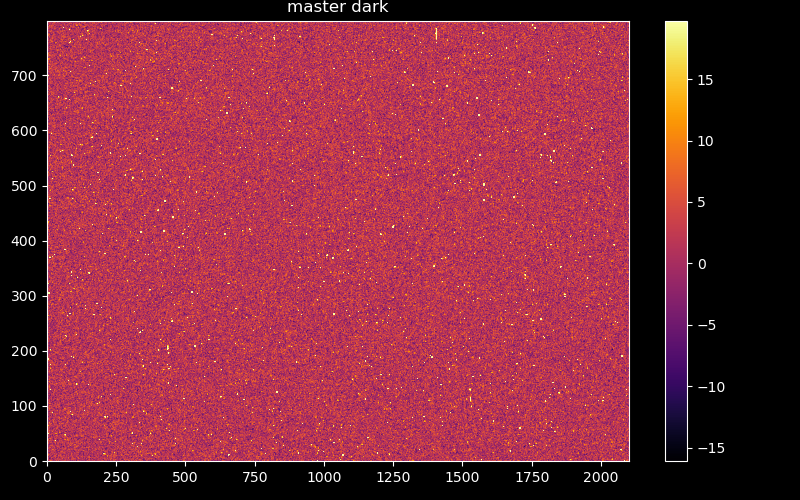

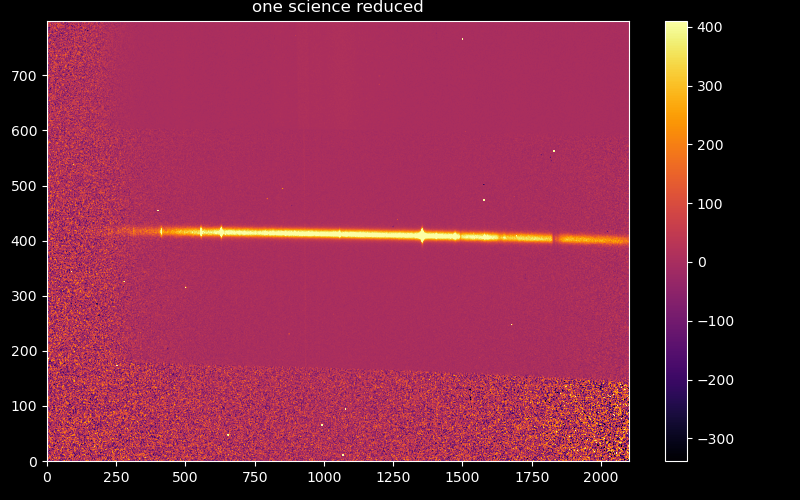

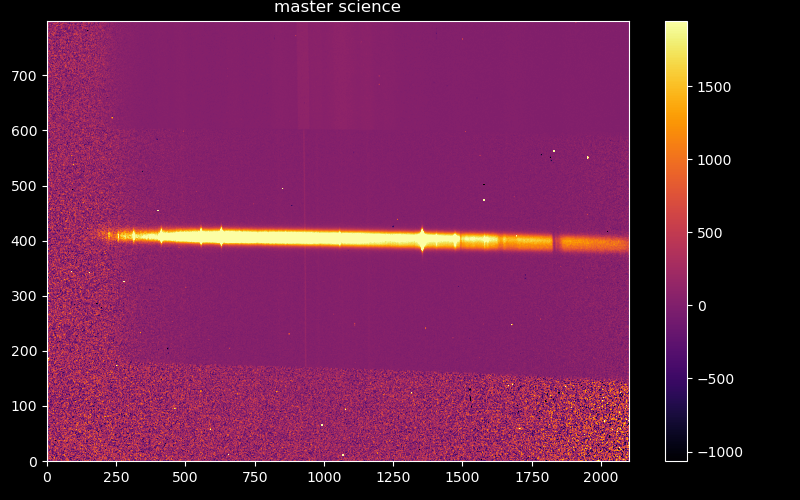

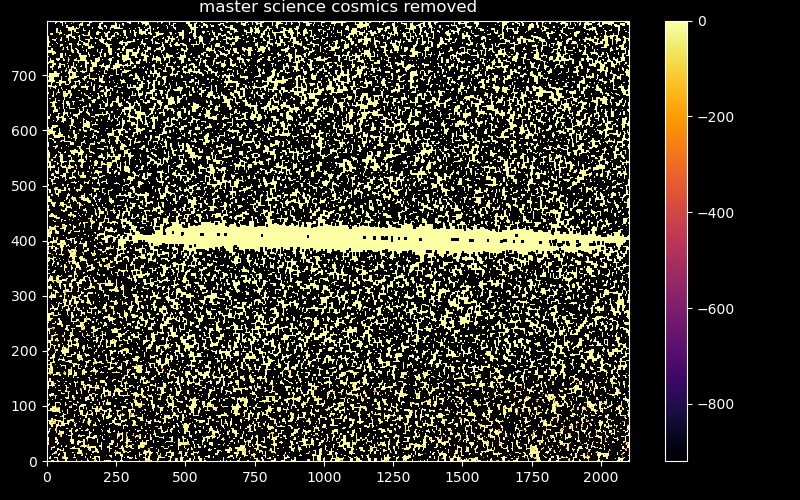

In [37]:
plt.close('all')
#master_bias = CCDData.read(CAPTURE_DIR + 'masterbias.fit')

#show_image(master_bias, 'master bias')
show_image(master_dark, 'master dark')
#show_image(master_flat, 'master flat')
#show_image(master_calib, 'master calib')
#show_image(master_sciences[0], 'one science reduced')
show_image(master_sciences[6], 'one science reduced')

show_image(master_science, 'master science')
show_image(master_science_clean, 'master science cosmics removed')

